**Machine Learning assignment 4: dimensionality reduction**

Read this notebook and do the exercises; then:

* Copy your exercise solutions into the skeleton code in `A4.py`, and you test them with `pytest` and `A4_test.py`. When you're satisfied that your code in `A4.py` passes the tests, commit and push it back to Github. You can also push your notebook -- that will never negatively impact your grade, but could give us an idea of what you did wrong for open questions.

* Make a PDF report answers to the open questions (as well as your graphics). It should be named `A4_s1234567890.pdf`, but using your own student number instead of 1234567890. Hand the PDF report in through Brightspace. Your answers don't need to be long, just be to the point -- _but illustrative examples are welcome._

* If you do not submit both `A4.py` to Github and the PDF report to Brightspace, you will fail this assignment.

* This is an individual assignment. Your code and report must be your own work.

---

Specific notes for this assignment:

* Make sure to look at the code that is not part of programming exercises, we sometimes give it to you because you need it later on.

* There are 8 programming exercises that are labelled with subsubsections that start with "Exercise [number]:".

* There are 5 regular open questions, 2 plot questions, and 1 open bonus question that you should answer in your report. These are labelled with subsubsections that start with "Question [number] [(bonus)  or (2 points) if applicable]:".

* The 8 programming exercises (`A4.py`) make up 40% of your grade. The 8 or 9 questions that end up in your report (`A4_[your ID].pdf`) make up the other 60% of your grade.

# Set-Up

## Import packages and functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as sk_scale
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.utils import shuffle as sk_shuffle

## Define some basic functions and classes

There are examples of usage of all of these below.

In [2]:
def helpful_eq(a, b, failing_is_good=False):
    """Basically `==` after rounding with prints. 
    `a` and `b` can be numbers or (>1D) (NumPy) arrays."""
    def print_bad_news():
        print(a)
        print("helpful_eq(...) fail: ^ does not equal:")
        print(b)

    try:
        if hasattr(a, "__len__"):
            r = np.allclose(a, b, atol=1e-3)
        else:
            r = round(a, 3) == round(b, 3)
        if failing_is_good:
            r = not r
        if not r:
            print_bad_news()
        return r
    except Exception as e:
        print_bad_news()
        print("And/or we encountered exception message")
        print(e)
        return False


def mean_squared_error(true, pred):
    """`true` and `pred` should be (numpy.nd)arrays with similar shapes.
    Returns mean (over instances/rows) of sum of squared feature difference (in columns)."""
    return np.mean(((true - pred) ** 2).mean(axis=1))


class NFolds:
    def __init__(self, X, y, n_folds=5, seed=42):
        """ Initialize the KFolds instance

        :param X: numpy.ndarray of feature columns 
        :param y: numpy.ndarray of labels
        :param n_folds: number of folds desired
        :param seed: random seed, if you want reproducible results (optional)

        After initialization, self.folds will store n_folds folds.
        Each fold is a pair of arrays with training indices and test indices.
        The folds are as evenly distributed in size as possible.
        All the test segments are pairwise disjoint.
        """
        self.X = X
        self.y = y
        self.n_folds = n_folds
        self.folds = []
        indices = np.arange(X.shape[0])
        if seed is not None:
            np.random.seed(seed=seed)
        np.random.shuffle(indices)
        fold_size = X.shape[0] / n_folds
        for fold_num in range(n_folds):
            test = indices[int(fold_num * fold_size): int((fold_num + 1) * fold_size)]
            train = np.concatenate([indices[: int(fold_num * fold_size)],
                                    indices[int((fold_num + 1) * fold_size):]])
            self.folds.append((train, test))

    def get_fold(self, fold_num):
        """ Get the training and test data of the fold_num-th fold

        :param fold_num: Which fold's division of the data to use
        :return: Training and test features/labels
        """
        train, test = self.folds[fold_num]
        X_train = self.X[train]
        X_test = self.X[test]
        y_train = self.y[train]
        y_test = self.y[test]
        return X_train, X_test, y_train, y_test

# Principal component analysis

Principal component analysis (PCA) is an unsupervised method for dimensionality reduction. The principal _components_ are vectors that can be considered as a direction in which the data is most variant. The first of these components "explains" more variance in the data than the second, and so forth. The _scores_ are numbers ("scalars") with which these components can be multiplied to reconstruct the original data. By taking only $k$ $d$-dimensional component vectors and an $n\times k$ score matrix we have a compressed _approximate_ representation of an $n\times d$-sized dataset. The information density of all involved numbers/vectors is hopefully higher.

We will use the singular value decomposition to implement our principal component analysis algorithm -- it is described around equation 10.2 on page 324 (344 in my .pdf) of Peter Flach's Machine Learning book.

## Load simple numerical dataset

Our simple, first dataset consists of four instances of measurements of two features. In terms of the mathematical symbols: this is our $n \times d = 4 \times 2$-sized matrix $\mathbf{X}$.

In [3]:
X = np.array([[0.0, 0.4], 
              [1.0, 2.0], 
              [2.0, 3.2], 
              [3.0, 5.3]])


## Center and scale

We need to normalize our dataset if we want PCA to consider all features potentially equally important. Specifically, we want all $d$ features to be centered on zero and have the same standard deviation.

### Exercise 1: implement `(un)center_and_(un)scale`

In [4]:
def center_and_scale(X):
    """`X` is a numpy.ndarray. Rows represent instances. Columns represent feature values.
    First output is a modified copy of `X` where mean of individual features is 0 and 
    standard deviation is 1. The second and third output are original values of said mean and 
    standard deviation respectively."""
    orig_mean = np.mean(X, 0)
    orig_std = np.std(X, 0)
    #Normalise dataset
    
    X_transform = X - orig_mean
    #X_normalised = (X_transform)/(np.linalg.norm((X_transform),axis=0))*np.sqrt(X.shape[0])
    X_normalised = X_transform / orig_std
    
    return X_normalised, orig_mean, orig_std


def uncenter_and_unscale(X_norm, orig_center, orig_std):
    """`X_norm` is a numpy.ndarray. Rows represent instances. Columns represent feature values,
    now with mean 0 and standard deviation 1. Output is a modified copy of `X_norm` with values of
    `orig_center` as column means and values of `orig_std` as column standard deviations. (This
    function thus reverses `center_and`scale`.)"""
    #raise NotImplementedError()
    #X_transform = X + orig_center 
    #X_orig = X_transform * ((X_transform.shape[0])**2 * np.linalg.norm((X_transform),axis=0))
    
    X_orig = (X_norm * orig_std) + orig_center
    return X_orig

X_norm, orig_center, orig_std = center_and_scale(X)

In [5]:
def test_center_and_scale():
    # And uncenter_and_unscale...
    X = np.array([[0.0, 0.5, 7], [1.0, 1.5, -10], [2.0, 4.5, 0], [3.0, 5.5, 999]])
    X_norm, orig_center, orig_std = center_and_scale(X)
    assert helpful_eq(X_norm.mean(), 0)
    assert helpful_eq(X_norm.var(), 1)
    sk_X_norm = sk_scale(X)
    assert helpful_eq(X_norm, sk_X_norm)
    assert helpful_eq(orig_center, [1.5, 3.0, 249.])
    assert helpful_eq(orig_std, [1.118, 2.062, 433.055])
    X = np.dot(np.random.rand(2, 2), np.random.randn(2, 100)).T
    csX = center_and_scale(X)
    assert helpful_eq(csX[0], sk_scale(X))
    assert helpful_eq(uncenter_and_unscale(*csX), X)

test_center_and_scale()

## Visualize our goal

Using https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html. You can use this cell as inspiration for the other programming exercises if you didn't manage to finish the earlier ones.

In [6]:
k = 1
sk_pca = PCA(n_components=k)
sk_X_norm = sk_scale(X)
sk_score = sk_pca.fit_transform(sk_X_norm)
sk_components = sk_pca.components_
X_norm_reconstr = sk_score @ sk_components  # @ is a standard matrix multiplication



print("Component(s) matrix:")
print(sk_components)
print("Score matrix")
print(sk_score)
print()
print(sk_X_norm.round(3))
print(f"Recreation of [centered and scaled matrix above] using {k} component(s):")
print(X_norm_reconstr.round(3))
mean_squared_error(sk_X_norm, X_norm_reconstr)

Component(s) matrix:
[[0.70710678 0.70710678]]
Score matrix
[[-1.86816932]
 [-0.60294921]
 [ 0.50407975]
 [ 1.96703879]]

[[-1.342 -1.3  ]
 [-0.447 -0.405]
 [ 0.447  0.266]
 [ 1.342  1.44 ]]
Recreation of [centered and scaled matrix above] using 1 component(s):
[[-1.321 -1.321]
 [-0.426 -0.426]
 [ 0.356  0.356]
 [ 1.391  1.391]]


0.002882207412825675


### Question 1: why can the two-dimensional data we stored in `X` be reconstructed so well using only one principal component?

This is because the principal component stores the relation between the two values belonging to each point in X, and because the matrix was rescaled and recentered before the principal component was calculated.

## Singular value decomposition
We use https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html for most of $\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{\mathrm{T}}$, where $\mathbf{U}$ is an $n\times r$ matrix, $\mathbf{\Sigma}$ is an $r\times r$ matrix, and $\mathbf{V}$ is a $d \times r$ matrix. We simplify and assume $d = r < n$ as in the book, which is practically fine but really not in line with the classical definition of an SVD. The NumPy function sort of works with this assumption/simplification as well, but goes further by returning only the diagonal elements of $\mathbf{\Sigma}$.

The `R_squared` variable contains the amount of variance the corresponding principal component "explains".

In [7]:
U, Sigma_elements, V_transpose = np.linalg.svd(X_norm, full_matrices=False)
Sigma = np.zeros((U.shape[1], V_transpose.shape[0]))
Sigma[:Sigma_elements.size, :Sigma_elements.size] = np.diag(Sigma_elements)
S_squared_sum = sum(S_i ** 2 for S_i in Sigma_elements)
R_squared = [S_i ** 2 / S_squared_sum for S_i in Sigma_elements]
print(U)
print(Sigma)
print(Sigma_elements)
print(V_transpose)
print(R_squared)

[[-0.66145151 -0.19228027]
 [-0.21348261 -0.19431549]
 [ 0.17847649  0.8454258 ]
 [ 0.69645762 -0.45883004]]
[[2.82434813 0.        ]
 [0.         0.15184749]]
[2.82434813 0.15184749]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
[0.9971177925871744, 0.0028822074128256807]


## Obtain $k$ principal components and score matrix

https://en.wikipedia.org/wiki/Principal_component_analysis#Singular_value_decomposition and some other sources call the $k$ principal components $\mathbf{W}_k$ and the corresponding score matrix $\mathbf{T}_k$. The book calls the score matrix $\mathbf{W}$ and the components $\mathbf{V}$, which makes more sense if we name the variables in our singular value decomposition as in $\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{\mathrm{T}}$. 

We will just name the $k\times d$ principal components matrix "components" and the $n\times k$ score matrix "score" so that we don't keep working with unidiomatic variables. The components matrix can be multiplied with the score matrix to create a reconstruction of $\mathbf{X}$. Here's an even bigger hint: the components are somewhere in $\mathbf{U}\mathbf{\Sigma}$ and the score matrix can be found in $\mathbf{V}^{\mathrm{T}}$.

### Exercise 2: implement `svd_to_components_and_score`

In [53]:
def svd_to_components_and_score(U, Sigma_elements, V_transpose, k):
    """ Input is output of `numpy.linalg.svd(..., full_matrices=False)` and `k` indicating # of 
    components. First output is `k`-by-d component numpy.ndarray; second output is n-by-`k` score 
    numpy.ndarray.
    """
    # U dim n x r; Sigma dim r x r; V dim d x r. 
    # component dim k x d; score dim n x k 
    # d = r < n => U dim n x d; Sigma dim d x d = V dim 
    # USigma dim n x d 
    Sigma[:Sigma_elements.size, :Sigma_elements.size] = np.diag(Sigma_elements)
    USigma = U @ Sigma
    components = V_transpose[:k, :]
    score = USigma[:, :k]
    return components, score

components, score = svd_to_components_and_score(U, Sigma_elements, V_transpose, k)
print("Component(s) matrix:")
print(components)
print("Score matrix")
print(score)

Component(s) matrix:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
Score matrix
[[-1.86816932 -0.02919728]
 [-0.60294921 -0.02950632]
 [ 0.50407975  0.12837578]
 [ 1.96703879 -0.06967219]]


In [54]:
def test_svd_to_components_and_score():
    for k in [1, 2]:
        X = sk_scale(np.array([[0.0, 0.4],
                               [1.0, 1.6],
                               [2.0, 2.4],
                               [3.0, 3.6]]))
        U, S, V_transpose = np.linalg.svd(X, full_matrices=False)
        components, score = svd_to_components_and_score(U, S, V_transpose, k)
        assert helpful_eq(components[0, 0], 0, failing_is_good=True)
        assert helpful_eq(components[0, 0], components[0, 1])
        assert helpful_eq(score[0, 0], -score[3, 0])
        assert helpful_eq(score[1, 0], -score[2, 0])
        np.random.seed(39)
        X = sk_scale(np.dot(np.random.rand(2, 2), np.random.randn(2, 100)).T)
        sk_pca = PCA(n_components=k)
        sk_score = sk_pca.fit_transform(X)
        sk_components = sk_pca.components_
        U, S, V_transpose = np.linalg.svd(X, full_matrices=False)
        components, score = svd_to_components_and_score(U, S, V_transpose, k)
        assert helpful_eq(sk_components, components)
        assert helpful_eq(sk_score, score)


test_svd_to_components_and_score()

## Reconstruct our data using $k=1$ principal components

If you don't have `orig_center` and `orig_std`, you can compare `X_norm` with its reconstruction.

In [10]:
print(X)
print(f"Recreation of [matrix above] using {k} components:")
X_norm_reconstr = score @ components
X_reconstr = uncenter_and_unscale(X_norm_reconstr, orig_center, orig_std)
print(X_reconstr.round(3))
mean_squared_error(X_norm, X_norm_reconstr)

[[0.  0.4]
 [1.  2. ]
 [2.  3.2]
 [3.  5.3]]
Recreation of [matrix above] using 1 components:
[[0.023 0.363]
 [1.023 1.963]
 [1.899 3.362]
 [3.055 5.212]]


0.0028822074128256755

### Question 3: make a scatter plot that contains true and reconstructed values $(k=1)$, as well as the single principal component.

It is easiest to use the centered and scaled versions of `X` and its reconstruction. You can optionally scale the component visualization with `R_squared` as follows. That is not so informative with $k=1$ but it might be nice to try with $k=2$. Here is some code that you can probably use to get an idea of how:

```
for i in range(k):
    horizontal = R_squared[i] * components[i, 0]
    vertical = R_squared[i] * components[i, 1]
    plt.arrow(0, 0, horizontal, vertical, head_width=0.05, color="red")
```

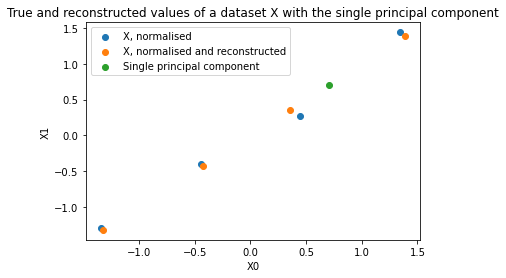

In [11]:

#Plot X_norm, X_norm but reconstructed and the single principal component. 
plt.scatter(X_norm[:,0], X_norm[:,1], label="X, normalised")
plt.scatter(X_norm_reconstr[:,0], X_norm_reconstr[:,1], label="X, normalised and reconstructed")
plt.scatter(components[0,0], components[0,1], label="Single principal component")

plt.title("True and reconstructed values of a dataset X with the single principal component")
plt.xlabel("X0")
plt.ylabel("X1")
plt.legend()

## Score and reconstruct _new_ data

We will now represent new data in terms of $k$ principal components. For that, we first need to normalize the "new" data's feature values using the "old" `orig_center` and `orig_std`, so that everything is comparable.

We get the new $\mathbf{V}^{\mathrm{T}}$ with $\mathbf{X} (\mathbf{U}\mathbf{\Sigma})^{-1}=\mathbf{X} (\mathbf{U}\mathbf{\Sigma})^{\mathrm{T}}$. It could be useful to try to figure out why.

### Exercise 3: implement `score_new_data`

In [12]:
def score_new_data(new_X, orig_center, orig_std, components):
    """`new_X` is a numpy.ndarray. Rows represent instances. Columns represent feature values.
    First, create a modified copy of `new_X` as if normalizing it using `orig_center` and 
    `orig_std`. These params refer to feature means and standard deviations respectively. 
    Output is a representation of this normalized `new_X` in terms of `components`, i.e., a score 
    matrix."""
    #Normalise new X 
    new_normalised_X = (new_X - orig_center)/orig_std
    #Obtain USigma
    
    score = new_normalised_X @ np.matrix.transpose(components)
    return score
    

print(X.round(3))
new_X = np.array([[0.5, 0.99],
                  [2.5, 4.42]])
# If you don't have `orig_center` and `orig_std`, you can come up with some fake values.
# (You can find the dimensions of these variables in their test function.)
new_score = score_new_data(new_X, orig_center, orig_std, components)
new_X_norm_reconstr = new_score @ components
print(uncenter_and_unscale(new_X_norm_reconstr, orig_center, orig_std).round(3))

[[0.  0.4]
 [1.  2. ]
 [2.  3.2]
 [3.  5.3]]
[[0.458 1.058]
 [2.53  4.372]]


In [13]:
def test_score_new_data():
    for k in [1,2,3]:

        X = sk_scale(np.array([[0.0, 0.4, -1, 1],
                               [1.0, 1.6, -2, 2],
                               [2.0, 3.4, -3, 3.5],
                               [3.0, 4.6, -4, 5]]))
        new_X = sk_scale(np.array([[0.5, 0.99, 1, -2],
                                   [2.5, 3.99, -42, -9]]))
        sk_pca = PCA(n_components=k)
        score = sk_pca.fit_transform(X)
        components = sk_pca.components_
        new_score = score_new_data(new_X, [1.42, 2.42, 4, 4], [1.11, 1.66, 2, 3], components)
        new_X_reconstr = new_score @ components
        if k == 1:
            assert helpful_eq(new_X_reconstr, 
                              np.array([[-0.93533774, -0.93443902,  0.93533774, -0.93414063],
                                        [-0.09948932, -0.09939373,  0.09948932, -0.09936199]]))
        elif k == 2:
            assert helpful_eq(new_X_reconstr, 
                              np.array([[-0.57078589, -1.07598312,  0.57078589, -1.52258937],
                                        [ 0.98203221, -0.51931478, -0.98203221, -1.84512183]]))
        elif k == 3:
            assert helpful_eq(new_X_reconstr, 
                              np.array([[-0.34009009, -2.06024096,  0.34009009, -1.        ],
                                        [ 1.06081081, -0.85542169, -1.06081081, -1.66666667]]))


test_score_new_data()

## Wrap our work in a `pca` function

This is fairly self-explanatory. You could create an object to keep track of so many variables, but you have seen that trick before; a dictionary works too. If you do not break anything that is already here, you could store more relatively small variables in the output.

In [14]:
def pca(X, k):
    """All components are explained above. If you did not complete `center_and_scale` or 
    `svd_to_components_and_score`, you can fit in the scikit-learn alternatives exemplified 
    (in the tests) above."""
    X_norm, orig_center, orig_std = center_and_scale(X)
    U, Sigma_elements, V_transpose = np.linalg.svd(X_norm, full_matrices=False)
    S_squared_sum = sum(S_i ** 2 for S_i in Sigma_elements)
    R_squared = [S_i ** 2 / S_squared_sum for S_i in Sigma_elements]
    #components, score = svd_to_components_and_score(U, Sigma_elements, V_transpose, k)
    sk_pca = PCA(n_components=k)
    sk_score = sk_pca.fit_transform(X)
    sk_components = sk_pca.components_
    components, score = sk_components, sk_score 
    return {
        'orig_center': orig_center,
        'orig_std': orig_std,
        'components': components,
        'score': score,
        'R_squared': np.array(R_squared)
    }


pca_dict = pca(X, k)
for key in pca_dict.keys():
    print(key)
    print(pca_dict[key].round(4))
    print()

orig_center
[1.5   2.725]

orig_std
[1.118 1.788]

components
[[0.5292 0.8485]]

score
[[-2.7666]
 [-0.8798]
 [ 0.6676]
 [ 2.9787]]

R_squared
[0.9971 0.0029]



# Big(ger) data

We will now use PCA in the pre-processing of a more realistic dataset, and test whether it helped in improving prediction accuracy and/or reducing model fitting and other computational time. We will use the support vector machine classifier of that you have seen before. The specific model is not important; that PCA or other pre-processing can help is. (And, to be fair, PCA and other pre-processing techniques can also have more costs than benefits when using other models.)

## Load/create more complicated dataset

There is a little more information about the dataset `load_breast_cancer` loads on https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic) and https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset. We modify the dataset to consist of more samples through repeats, but add a decent amount of noise (independently sampled from a normal distribution with mean zero and a quarter of that feature's own standard deviation). We also add two categorical features in the columns of `X` that are in `non_num_idx`. 

So the dataset does not represent what it's based on very closely anymore. But to give a little more information, in `X, y = load_breast_cancer(return_X_y=True)` set,  `X` has 569 instances of 30 numeric features but 10 categories of attributes:

0. radius (mean of distances from center to points on the perimeter)
1. texture (standard deviation of gray-scale values)
2. perimeter
3. area
4. smoothness (local variation in radius lengths)
5. compactness (perimeter^2 / area - 1.0)
6. concavity (severity of concave portions of the contour)
7. concave points (number of concave portions of the contour)
8. symmetry
9. fractal dimension (“coastline approximation” - 1)

Features are computed from a digitized image of a fine needle aspirate (FNA) (sample) from a tumor. They describe characteristics of the cell nuclei present in the image. The mean, standard error, and mean of the three largest values of these characteristics were computed for each of the 569 images/instances, resulting in 30 features. For instance, field 0 is mean radius, field 10 is radius standard error, field 20 is the mean of the three largest radii.

The `y` contains a 0 for malignant samples, and a 1 for benign ones.


In [15]:
def create_big_X_y():
    """It's not necessary to understand completely what is happening, but notice that 
    the columns whose indices are in `non_num_idx` represent categorical features."""
    X, y = load_breast_cancer(return_X_y=True)

    # Add some instances
    X = np.repeat(X, 10, axis=0)
    y = np.repeat(y, 10)

    X, y = sk_shuffle(X, y, random_state=11)

    # Add two categorical features (that have a 60% prob of being right)
    np.random.seed(42)
    X = np.hstack((np.random.binomial(1, 0.4 + 0.2 * y).reshape(-1, 1),
                   np.random.binomial(1, 0.4 + 0.2 * y).reshape(-1, 1),
                   X))
    non_num_idx = [0, 1]
    
    # Add noise to numerical features
    num = [i for i in range(X.shape[1]) if i not in non_num_idx]
    X[:, num] += np.random.normal(0, 0.25 *
                                  X[:, num].std(axis=0), X[:, num].shape)

    # Replace some % of numerical values with np.nan
    X_num_flat = X[:, num].flatten()
    n_to_remove = int(len(X_num_flat) * .1)
    to_remove = np.random.permutation(range(len(X_num_flat)))[:n_to_remove]
    X_num_flat[to_remove] = np.nan
    X[:, num] = X_num_flat.reshape(X[:, num].shape)

    return X, y, non_num_idx


# big_... name to not confuse with our previous simple `X`.
big_X, big_y, non_num_idx = create_big_X_y()
big_X.shape

(5690, 32)

## Already split off a test set

We will perform repeated cross-validation later on, but while we create and test our functions it is already useful to have a separation of training and test set in mind.

In [36]:
X_train, X_test, y_train, y_test = NFolds(big_X, big_y, seed=5).get_fold(0)
print(X_train)

[[ 1.          1.         15.06097903 ...  0.15495723  0.28133099
   0.08943424]
 [ 0.          0.         21.84106715 ...  0.22074183  0.23638334
   0.07476276]
 [ 0.          1.         13.38384299 ...  0.17935782  0.32982295
          nan]
 ...
 [ 0.          0.         19.38073173 ...  0.24628595  0.35549601
   0.07880792]
 [ 1.          0.         15.35308404 ...  0.13026943  0.2673978
   0.07985852]
 [ 0.          1.         15.77904129 ...         nan  0.32416498
   0.08275628]]


## Explore the training set

In [17]:
X_nanvar = np.nanvar(X_train,axis=0)
print(X_nanvar)


[2.49133427e-01 2.49269861e-01 1.30239321e+01 1.89255738e+01
 6.18336675e+02 1.29040402e+05 2.12158331e-04 2.94041160e-03
 6.63346011e-03 1.58491041e-03 7.95991391e-04 5.25961687e-05
 7.86259443e-02 3.22935870e-01 4.29950538e+00 2.07958994e+03
 9.38669449e-06 3.40239534e-04 9.54591729e-04 4.04140203e-05
 7.29441422e-05 7.60999841e-06 2.38950708e+01 4.02706724e+01
 1.17861009e+03 3.32851543e+05 5.58867645e-04 2.58921362e-02
 4.61476986e-02 4.49718848e-03 4.12840608e-03 3.47023685e-04]


### Question 4: can you come up with a feature transformation (for one or more column(s) of `X`) that would make the principal components express more of the data's variance?

There are some columns with a very low variance (value smaller than 0.0001). We could scale those features so that they weigh less than the features with a high variance, by for example scaling and centering them different, so that the PCA express more of the data's variance. 

## Replace missing _numerical_ values

We will use a simple mean imputation to replace the missing values. Remember that we do not want to use any information from our test set before our final evaluation.

### Exercise 4: implement `mean_impute`

In [18]:
def mean_impute(X_train, X_test):
    """We assume numpy.ndarrays `X_train` and `X_test` only have numpy.nan as missing values in 
    their numerical features (columns). The output should be modified copies of `X_train` and 
    `X_test` where the missing values are replaced by the mean of the column of `X_train` in which 
    the value was missing. (The test might enlighten you.)"""
    #Get mean values of X_train
    X_train_nanmean = np.nanmean(X_train, axis=0)
    
    for i in range(0, X_train.shape[1]):
        X_train[:,i] = np.nan_to_num(X_train[:,i], nan=X_train_nanmean[i])
        X_test[:,i] = np.nan_to_num(X_test[:,i], nan=X_train_nanmean[i])
        
    return X_train, X_test

#X_train, X_test = mean_impute(X_train, X_test)
print(X_train)

[[ 1.          1.         15.06097903 ...  0.15495723  0.28133099
   0.08943424]
 [ 0.          0.         21.84106715 ...  0.22074183  0.23638334
   0.07476276]
 [ 0.          1.         13.38384299 ...  0.17935782  0.32982295
          nan]
 ...
 [ 0.          0.         19.38073173 ...  0.24628595  0.35549601
   0.07880792]
 [ 1.          0.         15.35308404 ...  0.13026943  0.2673978
   0.07985852]
 [ 0.          1.         15.77904129 ...         nan  0.32416498
   0.08275628]]


In [19]:
def test_mean_impute():
    X_train = np.array([[1, 2, np.nan],
                        [3, 4, 5]])
    X_test = np.array([[np.nan, 0, 3]])
    X_train, X_test = mean_impute(X_train, X_test)
    assert helpful_eq(X_train, [[1., 2., 5.], [3., 4., 5.]])
    assert helpful_eq(X_test, [[2., 0., 3.]])
    big_X, big_y, non_num_idx = create_big_X_y()
    X_train, X_test, _, _ = NFolds(big_X, big_y, seed=5).get_fold(0)
    X_train, X_test = mean_impute(X_train, X_test)
    assert helpful_eq(np.mean(X_train, axis=1)[0], 62.12441680772882)
    assert helpful_eq(np.mean(X_test, axis=1)[0], 53.21256512320771)
    assert helpful_eq(np.mean(X_train), 57.90520707104668)
    assert helpful_eq(np.mean(X_test), 58.20296278479702)

test_mean_impute()

## Choose $k$ components

### Exercise 5: implement `only_num`

We want to perform PCA on only the numerical part of the dataset.

In [20]:
def only_num(X, non_num_idx):
    """The columns of numpy.ndarray `X` whose indices are stored in `non_num_idx` are not 
    numerical. Return a modified copy of `X` that does _not_ contain these columns."""
    
    return np.delete(X, non_num_idx, axis=1)

print(only_num(X_train, non_num_idx).round(3))

[[1.50610e+01 2.21970e+01 9.27830e+01 ... 1.55000e-01 2.81000e-01
  8.90000e-02]
 [2.18410e+01 2.07990e+01 1.28829e+02 ... 2.21000e-01 2.36000e-01
  7.50000e-02]
 [1.33840e+01 1.89070e+01 9.37420e+01 ... 1.79000e-01 3.30000e-01
          nan]
 ...
 [1.93810e+01         nan         nan ... 2.46000e-01 3.55000e-01
  7.90000e-02]
 [1.53530e+01 2.22540e+01 1.02181e+02 ... 1.30000e-01 2.67000e-01
  8.00000e-02]
 [1.57790e+01 1.66350e+01 9.07300e+01 ...         nan 3.24000e-01
  8.30000e-02]]


In [21]:
def test_only_num():
    X = np.array([[-1, 0, 1, 2],
                  [-3, 1, 4, 5]])
    assert helpful_eq(only_num(X, [1]), np.array([[-1, 1, 2],
                                                  [-3, 4, 5]]))
    big_X, big_y, non_num_idx = create_big_X_y()
    first_num_idx = min([i for i in range(big_X.shape[1]) if i not in non_num_idx])
    assert helpful_eq(only_num(big_X, non_num_idx)[0:2, 0], big_X[0:2, first_num_idx])


test_only_num()

### Question 5: what is a good number of principal components to continue with _and why_? (Base your answer only on `X_train`.)

A figure may be useful.

The amount of variance expressed in each component is given by the r-squared value, with the total of all r-squared adding up to 1. If we want to have the optimum number of principal components, we should plot an elbow plot and look where the elbow makes its sharpest turn.

This can be seen in the above plot to be at k=4, or about 63% of the total R_squared value. From this we conclude that a good number of principal components to continue with is 4.



In [22]:
k = 6
X_train, _ = mean_impute(X_train, X_test)
pca_dict = pca(only_num(X_train, non_num_idx), k)


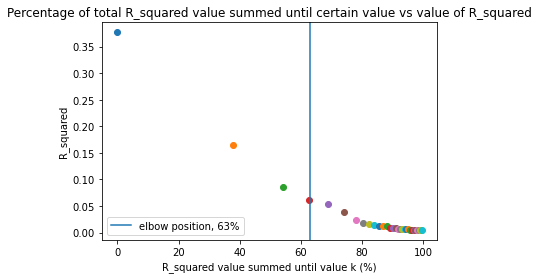

In [32]:
for k in range(0,30):
    X_train, _ = mean_impute(X_train, X_test)
    pca_dict = pca(only_num(X_train, non_num_idx), k)
    plt.scatter(np.sum(pca_dict.get("R_squared")[:k])/1*100, pca_dict.get("R_squared")[k])

plt.title("Percentage of total R_squared value summed until certain value vs value of R_squared")
plt.xlabel("R_squared value summed until value k (%)")
plt.ylabel("R_squared")
plt.axvline(x=62.85, label="elbow position, 63%")
plt.legend()
plt.show()

In [24]:
print(sum(pca_dict.get("R_squared")))
print(pca_dict.get("R_squared"))

#for key in pca_dict.keys():
    #print(key)
    #print(pca_dict[key].round(4))
    #print()
    


1.0000000000000004
[0.37696996 0.16513115 0.08512599 0.06068536 0.05325003 0.03891505
 0.02426658 0.01902658 0.01621124 0.01502651 0.01311184 0.01246551
 0.01181788 0.00923181 0.00863735 0.00782403 0.00723858 0.00694721
 0.00660765 0.00629406 0.0061532  0.00598381 0.00580004 0.0056339
 0.00553828 0.00540737 0.00535648 0.00527602 0.00514875 0.0049178 ]


## Replace `X`'s numerical features with score matrix

`X` has many numerical features and a couple of others, whose indices are storen in `non_num_idx`. We only performed PCA on the numerical features. We want to re-group the outcome of the PCA and the non-numerical part of `X` again.

### Exercise 6: implement `replace_num_with_score`

In [25]:
def replace_num_with_score(X, non_num_idx, score):
    """The columns of numpy.ndarray `X` whose indices are stored in `non_num_idx` are not 
    numerical. Return a modified copy of `X` that has unchanged non-numerical features but in 
    which the numerical features are replaced by the elements of the `score` numpy.ndarray."""
    # Assume only first features can be non-numerical to make our life easier
    assert all([i == non_num_idx[i] for i in range(len(non_num_idx))])
    #Modify X first 
    mod_X = np.zeros([X.shape[0], X.shape[1]])
    score_array = (np.array(score))
    j = 0 #counter variable
    for i in range(0, X.shape[1]):
        if i in non_num_idx:
            mod_X[:,i] = X[:,i]
        else:
            mod_X[:,i] = score_array[:,j]
            j = j + 1
    return mod_X
    
print(X_train.round(3))
print(pca_dict['score'].round(3))
print(replace_num_with_score(X_train, non_num_idx, pca_dict['score']).round(3))

[[ 1.     1.    15.061 ...  0.155  0.281  0.089]
 [ 0.     0.    21.841 ...  0.221  0.236  0.075]
 [ 0.     1.    13.384 ...  0.179  0.33   0.084]
 ...
 [ 0.     0.    19.381 ...  0.246  0.355  0.079]
 [ 1.     0.    15.353 ...  0.13   0.267  0.08 ]
 [ 0.     1.    15.779 ...  0.114  0.324  0.083]]
[[ 9.074300e+01  2.771400e+01 -2.588000e+01 ...  2.000000e-03
  -1.000000e-03 -1.000000e-03]
 [ 1.412051e+03  1.145350e+02 -5.490700e+01 ... -1.000000e-03
  -2.000000e-03  0.000000e+00]
 [ 1.699500e+01 -9.681000e+00 -2.282800e+01 ... -3.000000e-03
   2.000000e-03 -2.000000e-03]
 ...
 [ 6.623080e+02  1.008000e+02 -2.514100e+01 ...  1.000000e-03
  -2.000000e-03 -0.000000e+00]
 [-1.573000e+00  8.654000e+01 -1.633000e+00 ...  3.000000e-03
   1.000000e-03 -2.000000e-03]
 [-1.488510e+02 -3.203800e+01  7.934000e+00 ... -1.000000e-03
   3.000000e-03 -2.000000e-03]]


IndexError: index 29 is out of bounds for axis 1 with size 29

In [26]:
def test_replace_num_with_score():
    X = np.array([[1, 2.1, 4.3],
                  [0, 4.2, 5.3]])
    X = replace_num_with_score(X, [0], [[0,  1], [3,  2]])
    assert helpful_eq(X, [[1, 0, 1], [0, 3, 2]])
    X = np.array([[1, 2.1, 4.3]])
    X = replace_num_with_score(X, [0, 1], [[50]])
    assert helpful_eq(X, [[1, 2.1, 50]])


test_replace_num_with_score()

## Wrap pre-processing in a function

In [27]:
def preprocess(X_train, X_test, non_num_idx, pca_k=False):
    """Returns modified copies of `X_train` and `X_test` in which at least the missing values are
    imputed. If `pca_k` is not False but a positive integer, perform PCA as above, and replace
    numerical features (column indices not in `non_num_idx` with elements of the score matrix.
    The outcome of the `pca` function is returned as third value, or `None` if no PCA is done."""
    X_train, X_test = mean_impute(X_train, X_test)
    if pca_k > 0:
        pca_dict = pca(only_num(X_train, non_num_idx), pca_k)
        X_train_with_score = replace_num_with_score(X_train, non_num_idx, pca_dict['score'])
        X_test_s = score_new_data(only_num(X_test, non_num_idx), pca_dict['orig_center'], 
                                  pca_dict['orig_std'], pca_dict['components'])
        X_test_with_score = replace_num_with_score(X_test, non_num_idx, X_test_s)
        return X_train_with_score, X_test_with_score, pca_dict
    else:
        return X_train, X_test, None

## Evaluate PCA as part of pre-processing

We will use repeated cross validation with https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html fit to and predicting exactly the same data. By "repeated", we mean performing `n_repeats` divisions of the data into `n_folds` and having each of these folds as test set once. Compared to doing cross validation just once, this gives a stabler estimate of computation time and accuracy/loss. We are interested in estimating and comparing both of these quantities. To do that fairly, we use the same data splitting and model fitting seeds.

We will use the IPython magic command `%%time` in the beginning of a cell to see the time it -- the cell -- takes to execute.

In [28]:
n_repeats = n_folds = 2  # you may want to lower this to, e.g., 2 while working on the function

### Exercise 7: implement `repeated_cross_validation`

In [30]:
def repeated_cross_validation(X, y, n_repeats, n_folds, non_num_idx, pca_k=False):
    """For i = 0, ...`n_repeats`, create `X` and `y` folds with seed i. Then perform regular
    cross validation per set of folds. This regular CV includes 
    `preprocess(X_train, X_test, non_num_idx, pca_k)` and training an
    `SVC(random_state=(i+1)*(j+1))` where `j` is the index of the test fold. Return an 
    `n_repeats`-by-`n_folds` numpy.ndarray of mean accuracies per test fold."""
    j = 0 # counter variable for n_folds 
    X_train = np.empty([n_repeats, n_folds,int(X.shape[0]/n_folds), X.shape[1]]) #dim repeats x folds x X x y 
    X_test = X_train
    y_train = np.empty([n_repeats, n_folds,int(X.shape[0]/n_folds)])
    y_test = y_train
    for i in range(0, n_repeats):
        #Create X,y folds 
        for j in range(0, n_folds):
            X_train[i,j,:,:],X_test[i,j,:,:],y_train[i,j,:],y_test[i,j,:]=NFolds(X, y, n_folds = n_folds, seed=i).get_fold(j)
            #a,b,c,d = NFolds(X, y, n_folds = n_folds, seed=i).get_fold(j)]

    #Preprocess and perform SVC
    for i in range(0, n_repeats):
        for l in range(0, n_folds):
            X_train1, X_test1 = preprocess(X_train[i,l,:,:],X_test[i,l,:,:], non_num_idx, pca_k)
            

In [31]:
%%time
k = 5
accuracies_pca = repeated_cross_validation(big_X, big_y, n_repeats, n_folds, non_num_idx, pca_k=k)
#print(accuracies_pca.round(3))
#print(f'Accuracy with PCA: {round(np.mean(accuracies_pca), 3)}' +
      #f'+- {round(np.std(accuracies_pca), 3)}')

IndexError: index 5 is out of bounds for axis 1 with size 5

In [47]:
def test_repeated_cross_validation():
    X, y = load_breast_cancer(return_X_y=True)
    test_mean_impute()
    nn_idx = []
    accuracies = repeated_cross_validation(X, y, 2, 2, nn_idx, pca_k=False)
    assert helpful_eq(accuracies, [[0.91549296, 0.89824561],
                                   [0.9084507,  0.91578947]])
    accuracies_pca = repeated_cross_validation(X, y, 2, 2, nn_idx, pca_k=2)
    assert helpful_eq(accuracies_pca, [[0.91549296, 0.92631579],
                                       [0.92605634, 0.93684211]])
    X, y = load_breast_cancer(return_X_y=True)
    test_mean_impute()
    nn_idx = [0, 1, 2]
    accuracies = repeated_cross_validation(X, y, 4, 3, nn_idx, pca_k=False)
    assert helpful_eq(np.array(accuracies).shape, (4, 3))
    assert helpful_eq(accuracies, [[0.92592593, 0.89473684, 0.91052632],
                                   [0.8994709,  0.89473684, 0.92105263],
                                   [0.91005291, 0.89473684, 0.92631579],
                                   [0.92592593, 0.91052632, 0.91052632]])
    accuracies_pca = repeated_cross_validation(X, y, 4, 3, nn_idx, pca_k=2)
    assert helpful_eq(accuracies_pca, [[0.92063492, 0.88947368, 0.91578947],
                                       [0.88888889, 0.9,        0.9       ],
                                       [0.8994709,  0.92105263, 0.9       ],
                                       [0.93121693, 0.87894737, 0.91052632]])


test_repeated_cross_validation()

NameError: name 'repeated_cross_validation' is not defined

In [46]:
%%time
accuracies = repeated_cross_validation(big_X, big_y, n_repeats, n_folds, non_num_idx)
print(accuracies.round(3))
print(f'Accuracy without PCA: {round(np.mean(accuracies), 3)}' +
      f'+- {round(np.std(accuracies), 3)}')

NameError: name 'repeated_cross_validation' is not defined

### Question 6: how do the computation time and accuracies differ between the repeated evaluations with and without PCA, and how do you explain this?

If you use a different $k$ than you chose in question 5, specify it. We only looked at one specific training set in Q5, so your answer there is not necessarily wrong if you pick something else here.

The calculations with PCA tend to be faster, which is explained by the fact that the PCA simplifices the dataset by reducing the dimension, so that less complex computation is required. The accuracy is lower though, which is the cost of this simplification.


### Question 7 (bonus): test your theory.

You may include _relevant_ (psuedo-)code and figures in your report. It's fine if you (partially) falsify your theory too, as long as it -- the theory -- made sense in the first place.

### Question 8: can you describe a situation where (or model for which) PCA would not help?

A situation where PCA would not help is a dataset where one would expect the different features not to be related. As PCA reduces the dimension of a dataset by calculating a relation between the different features, it does not make sense to do so where there are no relations expected to be found, and might even cause the model to lose efficiency. 

## Interpret principal components

### Question 9: make scatterplots of 1: (train/test/all) points expressed in terms of the first two principal components; 2: the first two numerical features.

Make sure the labels of the points are displayed somehow, so that we can get a rough idea of how well the malignant and benign samples can be distinguished using only the first two principal components.

This requires you to run PCA with $k \geq 2$, but you could use https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html on this dataset as well.

In [52]:
big_X, big_y, non_num_idx = create_big_X_y()
X_train, X_test, y_train, y_test = NFolds(big_X, big_y, seed=5).get_fold(0)
X_train, X_test = mean_impute(X_train, X_test)

k = 2
pca = PCA(n_components = k)
mod_X_train = pca.fit_transform(X_train)
mod_X_score = pca.transform(X_test)
for i in range(0, mod_X_train.shape[0]):
    plt.scatter(mod_X_train[i,0], mod_X_train[i,1], label="training points", c=r)
for i in range(0, mod_X_test.shape[0])
    plt.scatter(mod_X_score[i,0], mod_X_train[i,1], label="test points", c=b)
plt.title("Plot of the dataset expressed in terms of the first two principal components")
plt.xlabel("k_0")
plt.ylabel("k_1")
plt.legend()
plt.show()


ValueError: Image size of 471x68318 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [ ]:
raise NotImplementedError()

In [46]:
for i in range(pca_dict['components'].shape[1]):
    print("{:02d}".format(i), pca_dict['components'][:2, i].round(3))

00 [0.005 0.004]
01 [0.002 0.   ]
02 [0.032 0.026]
03 [0.488 0.87 ]
04 [ 0. -0.]
05 [0. 0.]
06 [0. 0.]
07 [0. 0.]
08 [ 0. -0.]
09 [-0. -0.]
10 [0. 0.]
11 [-0.  0.]
12 [0.002 0.001]
13 [0.049 0.021]
14 [-0. -0.]
15 [0. 0.]
16 [0. 0.]
17 [0. 0.]
18 [-0.  0.]
19 [-0. -0.]
20 [0.006 0.003]
21 [ 0.003 -0.001]
22 [0.044 0.021]
23 [ 0.87  -0.492]
24 [ 0. -0.]
25 [ 0. -0.]
26 [0. 0.]
27 [0. 0.]
28 [ 0. -0.]
29 [ 0. -0.]


### Question 10 (2 points): what do the (first two) principal components represent when you think back to what the numerical features are based on?

Those represent the features with the two highest variances. For this dataset, those features are number 6 and 26; which correspond to the mean of the compactness and the mean of the three largest concavities. 

## Reconstruct numerical features from score matrix

Finally, we want to reconstruct our numerical data on its original scale from its score. PCA with $k \ll d$ is not supposed to be lossless (i.e., perfect) compression, so our results might not look great, but this is a nice exercise.

This may seem more daunting than the other programming exercises but it is just a combination of things we have done before. The docstring contains an outline, and the first case in the `test_` function might help as well.

### Exercise 8: implement `approx_X_from_X_with_score`

In [ ]:
def approx_X_from_X_with_score(X_with_score, pca_dict, non_num_idx):
    """Obtain the score matrix from the `non_num_idx` columns of `X_with_score`. Then reconstruct
    the feature values they originally represented using the PCA outcome stored in `pca_dict`. 
    Return these values in the same format as the original matrix, without forgetting the 
    `non_num_idx` columns."""
    raise NotImplementedError()


_, X_test_with_score, pca_dict = preprocess(X_train, X_test, non_num_idx, pca_k=2)
X_test_reconstr = approx_X_from_X_with_score(X_test_with_score, pca_dict, non_num_idx)
print(X_test[0].round(3))
print(X_test_reconstr[0].round(3))

In [ ]:
def test_approx_X_from_X_with_score():
    X_train = np.array([[0.0, 0.4], 
                        [1.0, 1.6], 
                        [2.0, 3.4], 
                        [3.0, 4.6]])
    X_test = np.array([[4, 5.6]])
    non_num_idx = []
    _, X_test_w_score, pca_dict = preprocess(X_train, X_test, non_num_idx, pca_k=1)
    assert helpful_eq(X_test_w_score, [[2.93797197]])
    # ^ tests only if mistake is in previous functions
    X_test_reconstr = approx_X_from_X_with_score(X_test_w_score, pca_dict, non_num_idx)
    assert helpful_eq(X_test_reconstr, [[3.82267078, 5.85623919]])
    assert helpful_eq(mean_squared_error(X_test, X_test_reconstr), 0.04855208630760682)

    X, y, non_num_idx = create_big_X_y()
    X_train, X_test, y_train, y_test = NFolds(X, y, seed=5).get_fold(0)
    X_train, X_test = mean_impute(X_train, X_test)
    _, X_test_w_score, pca_dict = preprocess(X_train, X_test, non_num_idx, pca_k=2)
    X_test_reconstr = approx_X_from_X_with_score(X_test_w_score, pca_dict, non_num_idx)
    assert helpful_eq(X_test_reconstr[0:5, -1], 
                      [0.07272649, 0.08546382, 0.07856379, 0.07790174, 0.10962264])
    assert helpful_eq(mean_squared_error(X_test, X_test_reconstr), 2760.755214107711)


test_approx_X_from_X_with_score()